TODO:
- [ ] Grad flow for different layers (Conv, RNN, etc.)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42, strict=True)

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../model/act_func/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Implement Activation Functions

In [3]:
act_fn_by_name = {}

## Sigmoid and Tanh

In [4]:
class Sigmoid(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
    '''
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

act_fn_by_name['sigmoid'] = Sigmoid


class StableSigmoid(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
    '''
    def forward(self, x):
        return 4 / (1 + torch.exp(-x)) - 2

act_fn_by_name['stablesigmoid'] = StableSigmoid


class Softmax(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softmax.html#torch.nn.Softmax
    '''
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(x)
        sum_exp_x = torch.sum(exp_x, dim=self.dim, keepdim=True)
        return exp_x / sum_exp_x
        # return F.softmax(x, self.dim, _stacklevel=5)

# act_fn_by_name['softmax'] = Softmax  # let's skip this rn :(


class Tanh(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Tanh.html#torch.nn.Tanh
    '''
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanh'] = Tanh


class Tanhshrink(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.Tanhshrink.html
    '''
    def forward(self, x):
        return x - (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanhshrink'] = Tanhshrink


class Softplus(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softplus.html#torch.nn.Softplus
    '''
    def __init__(self, beta=1, threshold=20):
        super().__init__()
        self.beta = beta
        self.threshold = threshold

    def forward(self, x):
        softplus =  1/self.beta * torch.log(1 + torch.exp(self.beta * x))
        return torch.where(x > self.threshold, x, softplus)

act_fn_by_name['softplus'] = Softplus


class Mish(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Mish.html#torch.nn.Mish
    '''
    def forward(self, x):
        soft_plus = torch.nn.functional.softplus(x)
        tanh_x = torch.tanh(soft_plus)
        return x * tanh_x

act_fn_by_name['mish'] = Mish

## ReLU and Swish

In [5]:
class ReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ReLU.html#torch.nn.ReLU
    '''
    def forward(self, x):
        # return torch.max(0, x)
        return x * (x > 0).float()

act_fn_by_name['relu'] = ReLU


class LeakyReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU
    '''
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.neg_slop = negative_slope
        
    def forward(self, x):
        return torch.where(x > 0, x, self.neg_slop * x)

act_fn_by_name['leakyrelu'] = LeakyReLU


class PReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.PReLU.html#torch.nn.PReLU
    '''
    def __init__(self, num_parameters=1, init=0.25):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_parameters).fill_(init))

    def forward(self, x):
        return torch.where(x > 0, x, self.weight * x)

# act_fn_by_name['prelu'] = PReLU  # also skip this :(


class ELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ELU.html#torch.nn.ELU
    '''
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.alpha * (torch.exp(x) - 1))

act_fn_by_name['elu'] = ELU
    

class SiLU(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html
    '''
    def forward(self, x):
        return x * torch.sigmoid(x)

act_fn_by_name['silu'] = SiLU


class GELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.GELU.html#torch.nn.GELU
    '''
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                np.sqrt(2 / torch.pi) * (x + 0.044715 * torch.pow(x, 3))
                )
            )

act_fn_by_name['gelu'] = GELU

In [6]:
# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]

cprint(act_fns)

<module> -> act_fns:
[Sigmoid(),
 StableSigmoid(),
 Tanh(),
 Tanhshrink(),
 Softplus(),
 Mish(),
 ReLU(),
 LeakyReLU(),
 ELU(),
 SiLU(),
 GELU()]


# Analysing the Effect of Activation Functions: NN

In [7]:
class BaseNN(nn.Module):
    def __init__(self, act_fn, input_size=784, hidden_sizes=[512, 256, 256, 128], num_classes=10):
        super().__init__()
        
        self.act_fn = act_fn
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index-1], 
                          layer_sizes[layer_index]),
                self.act_fn
                ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # reshape img to flat tensor
        # x = x.view(x.size(0), -1)
        x = x.view(-1, self.input_size)
        x = self.layers(x)
        return x
        

In [9]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(
    root=DATASET_PATH, 
    train=True, 
    download=True, 
    transform=transform
)

test_set = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform
)


In [10]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False)

val_loader = DataLoader(
    val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = DataLoader(
    test_set, batch_size=1024, shuffle=True, drop_last=False)

train_loader_small = DataLoader(
    train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True)

Define some utils

In [12]:
_get_file_name = lambda model_path, model_name, extension='.tar': os.path.join(model_path, model_name + extension)


def load_model(model_path, model_name, act_fn, net=None, **kargs):
    """
    Loads a saved model from disk.
    """
    model_file = _get_file_name(model_path, model_name)
    if net is None:
        net = BaseNN(act_fn=act_fn, **kargs)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net


def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    os.makedirs(model_path, exist_ok=True)
    model_file = _get_file_name(model_path, model_name)
    torch.save(model.state_dict(), model_file)


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

# Train the NN

Training BaseNetwork with sigmoid activation...
Model file exists, but will be overwritten...


[Epoch 26] Train Acc: 10.29%, Val Acc: 10.27%:  50%|█████     | 25/50 [05:13<05:13, 12.54s/it]


Early stopping due to no improvement over the last 15 epochs


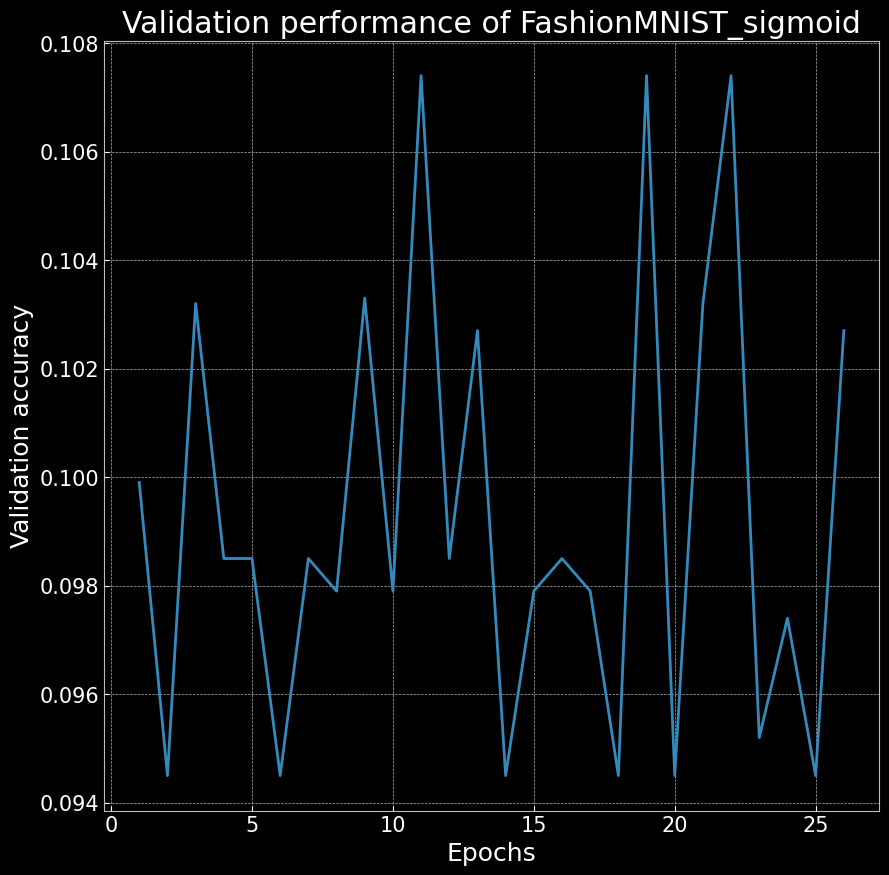

============= Test accuracy: 10.00% ==============

Training BaseNetwork with stablesigmoid activation...
Model file exists, but will be overwritten...


[Epoch 50] Train Acc: 88.76%, Val Acc: 87.24%: 100%|██████████| 50/50 [10:04<00:00, 12.09s/it]


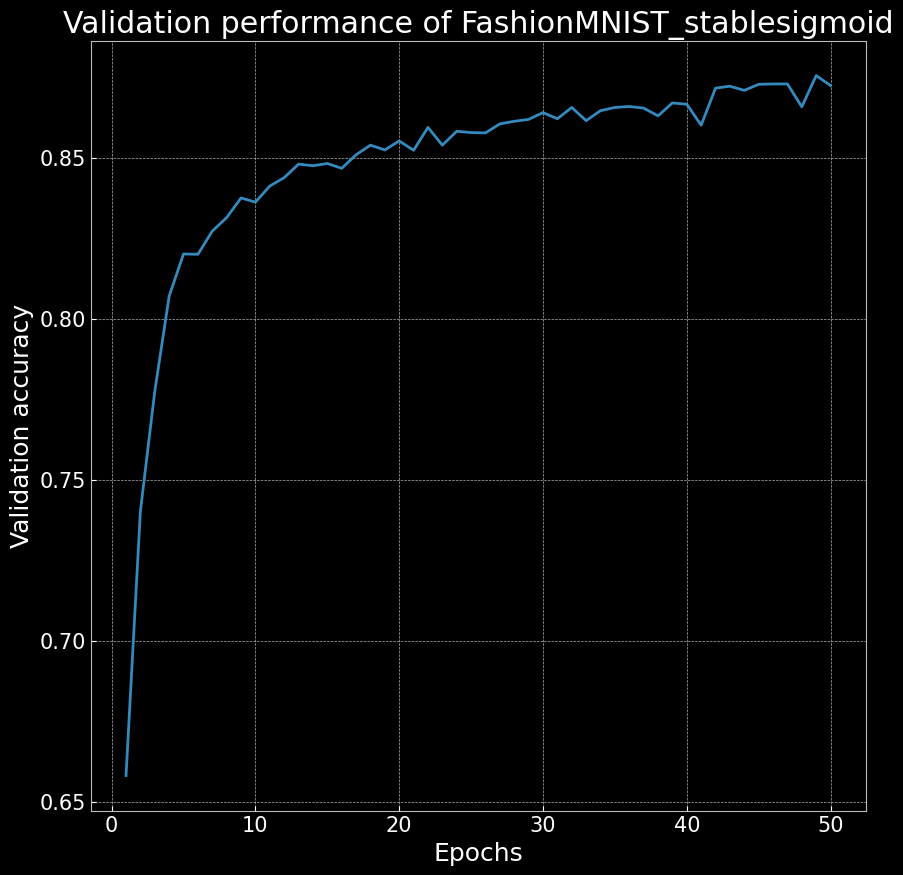

============= Test accuracy: 86.24% ==============

Training BaseNetwork with tanh activation...
Model file exists, but will be overwritten...


[Epoch 50] Train Acc: 90.91%, Val Acc: 87.83%: 100%|██████████| 50/50 [10:08<00:00, 12.16s/it]


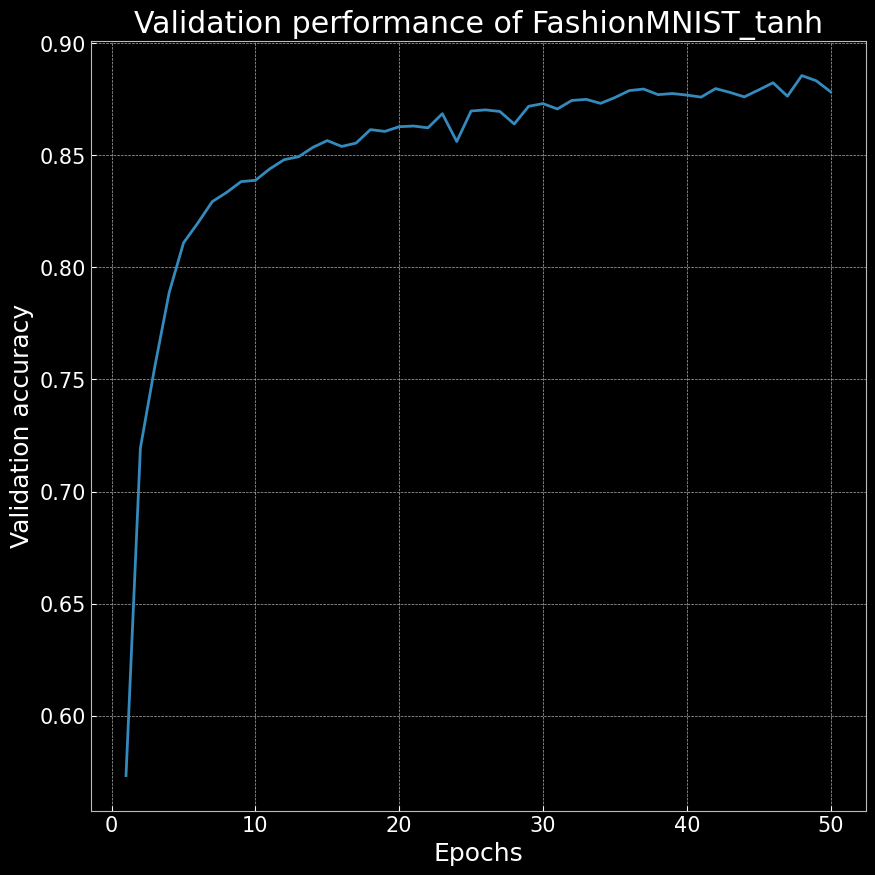

============= Test accuracy: 87.06% ==============

Training BaseNetwork with tanhshrink activation...


[Epoch 19] Train Acc: 09.83%, Val Acc: 09.45%:  36%|███▌      | 18/50 [03:50<06:50, 12.81s/it]


Early stopping due to no improvement over the last 15 epochs


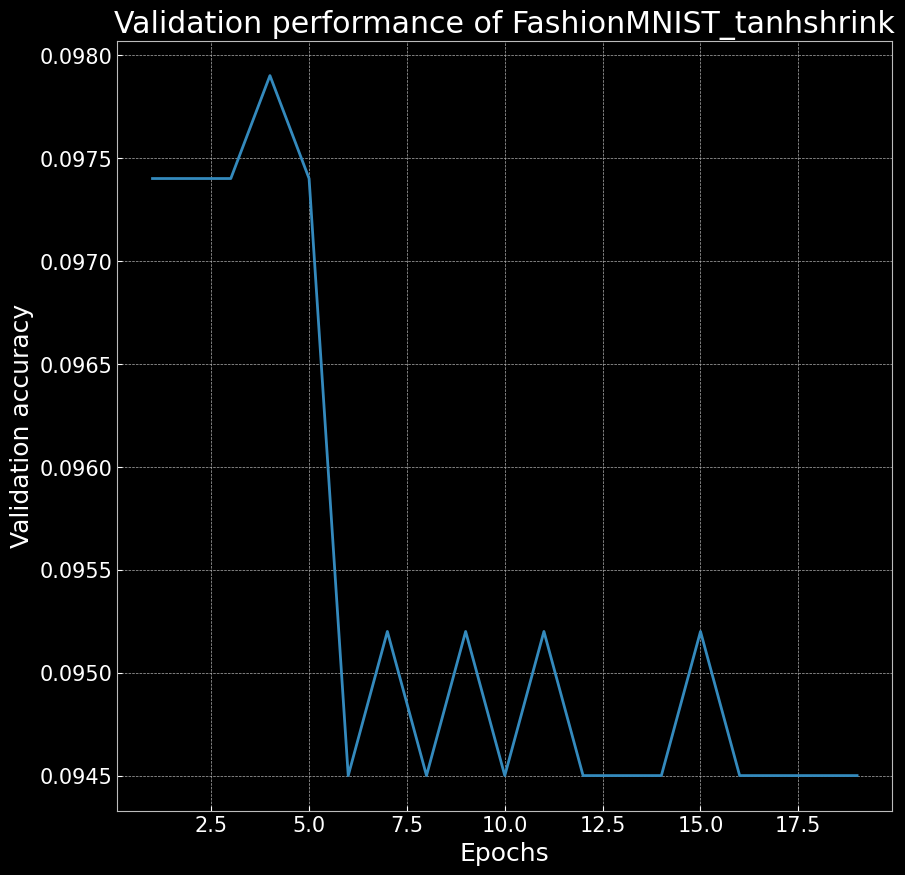

============= Test accuracy: 10.00% ==============

Training BaseNetwork with softplus activation...


[Epoch 50] Train Acc: 87.00%, Val Acc: 85.76%: 100%|██████████| 50/50 [10:05<00:00, 12.11s/it]


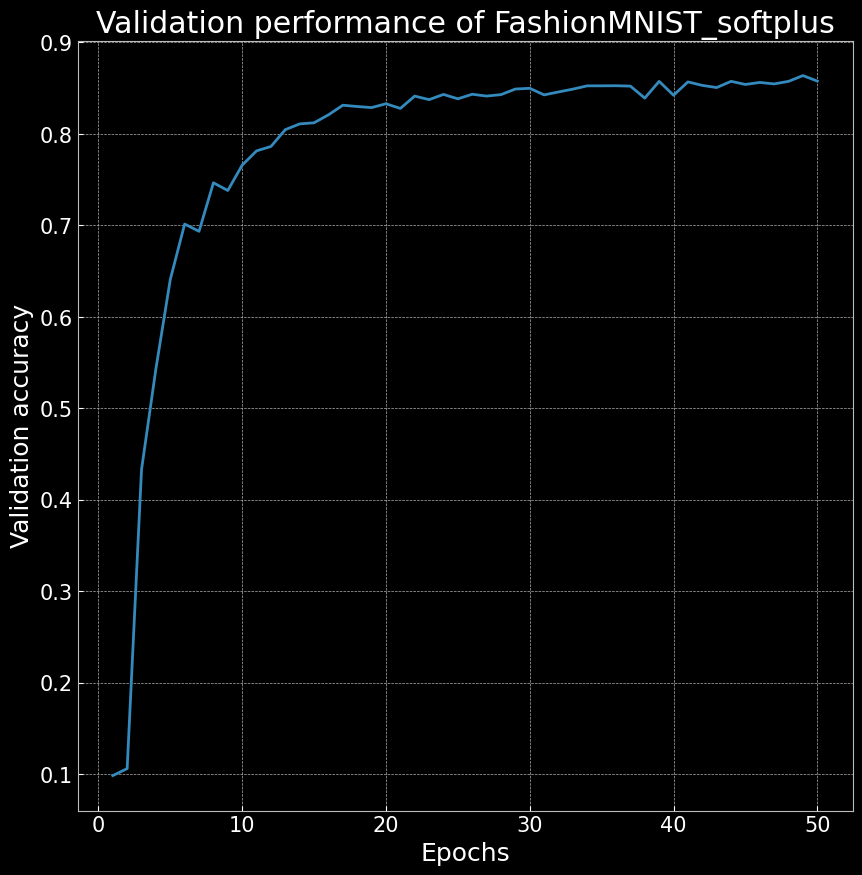

============= Test accuracy: 84.72% ==============

Training BaseNetwork with mish activation...


[Epoch 50] Train Acc: 89.88%, Val Acc: 88.42%: 100%|██████████| 50/50 [10:01<00:00, 12.03s/it]


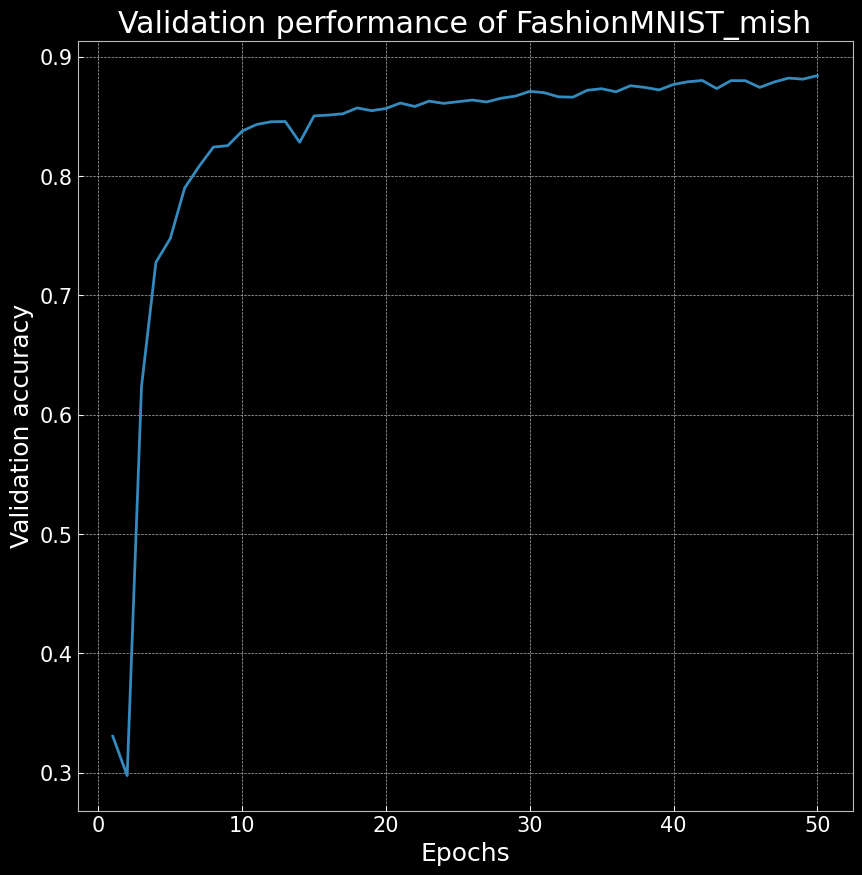

============= Test accuracy: 87.36% ==============

Training BaseNetwork with relu activation...
Model file exists, but will be overwritten...


[Epoch 50] Train Acc: 92.24%, Val Acc: 88.01%: 100%|██████████| 50/50 [09:59<00:00, 11.98s/it]


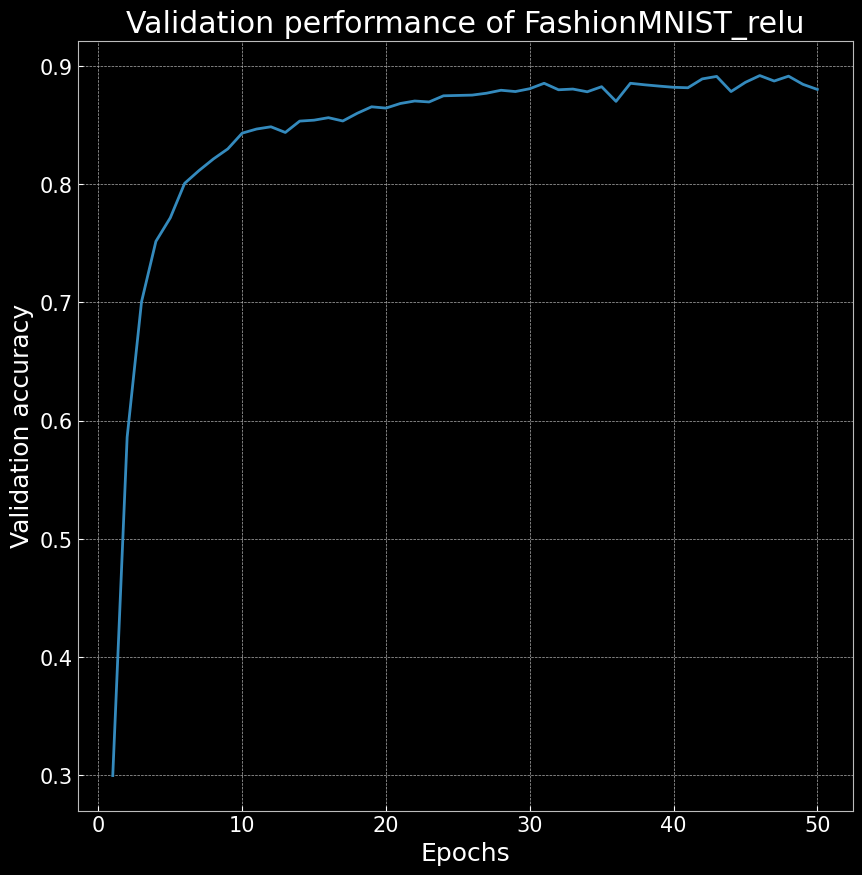

============= Test accuracy: 87.16% ==============

Training BaseNetwork with leakyrelu activation...
Model file exists, but will be overwritten...


[Epoch 50] Train Acc: 92.10%, Val Acc: 87.48%: 100%|██████████| 50/50 [10:01<00:00, 12.03s/it]


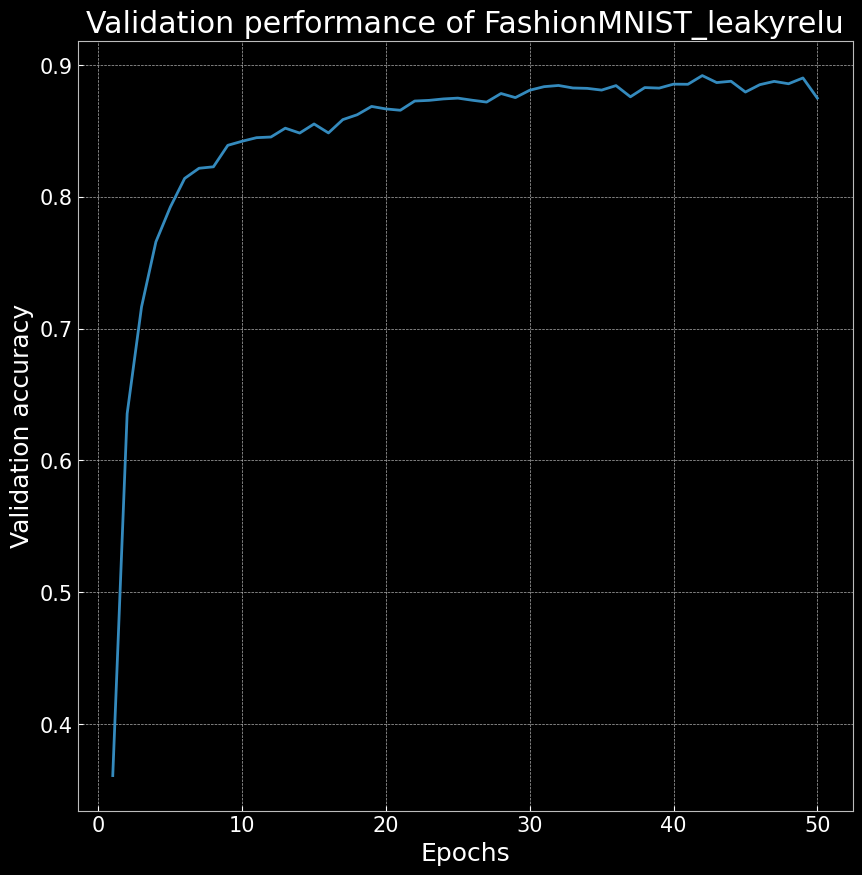

============= Test accuracy: 86.60% ==============

Training BaseNetwork with elu activation...
Model file exists, but will be overwritten...


[Epoch 50] Train Acc: 92.44%, Val Acc: 88.28%: 100%|██████████| 50/50 [10:02<00:00, 12.04s/it]


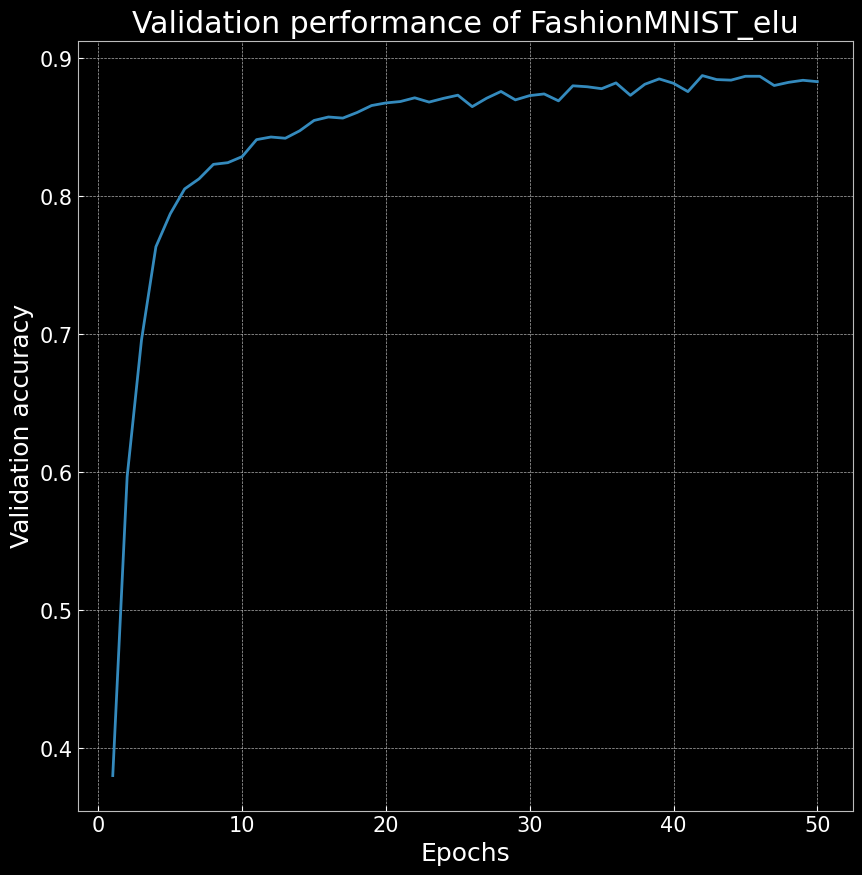

============= Test accuracy: 87.33% ==============

Training BaseNetwork with silu activation...


[Epoch 50] Train Acc: 88.79%, Val Acc: 87.62%: 100%|██████████| 50/50 [09:59<00:00, 11.98s/it]


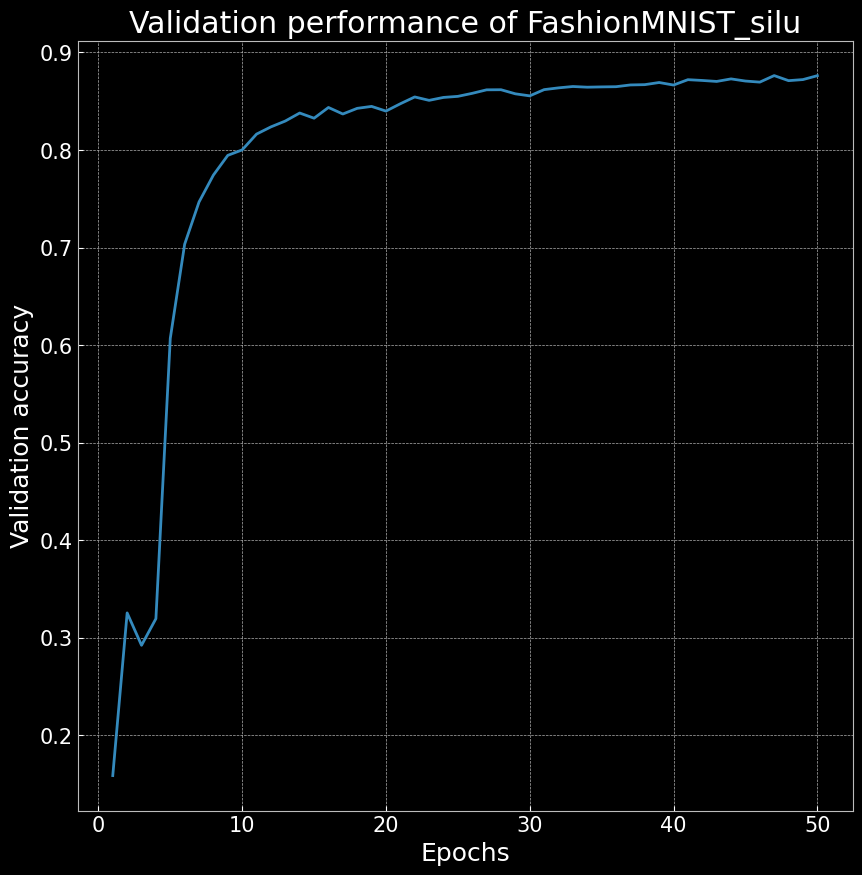

============= Test accuracy: 86.73% ==============

Training BaseNetwork with gelu activation...


[Epoch 50] Train Acc: 90.33%, Val Acc: 88.06%: 100%|██████████| 50/50 [10:04<00:00, 12.10s/it]


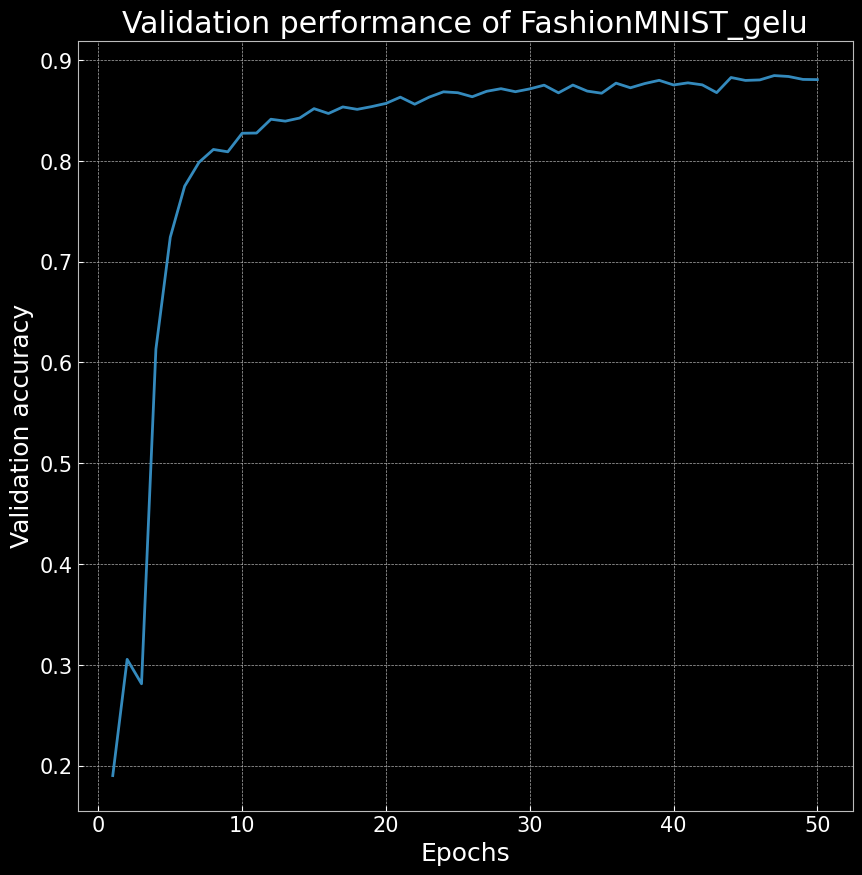

============= Test accuracy: 87.40% ==============



In [13]:
def train_model(
        net, 
        max_epochs=50, 
        patience=99, 
        train_loader=train_loader, 
        save_name='temp', 
        overwrite=False, 
        **kargs):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_file_name(CHECKPOINT_PATH, save_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        load_model(
            model_path=CHECKPOINT_PATH, 
            model_name=save_name, 
            net=net, 
            act_fn=net.act_fn)
        test_acc = test_model(net, test_loader)
        print((f" Test Acc: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
        return test_acc

    elif file_exists:
        print("Model file exists, but will be overwritten...")
            
    # Defining optimizer, loss and data loader
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
    criterion = nn.CrossEntropyLoss() 

    val_scores = []
    best_val_epoch = -1
    for epoch in (t := trange(max_epochs)):
        net.train()
        true_preds, count = 0., 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            preds = net(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]

        train_acc = true_preds / count

        # val
        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        t.set_description(f"[Epoch {epoch+1:2d}] Train Acc: {train_acc*100.0:05.2f}%, Val Acc: {val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            save_model(net, CHECKPOINT_PATH, save_name)
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping due to no improvement over the last {patience} epochs")
            break

    # Plot a curve of the validation accuracy
    plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title(f"Validation performance of {save_name}")
    plt.savefig(f"{_get_file_name(CHECKPOINT_PATH, save_name, "")}_val_performance.png")
    plt.show()
    plt.close()
    
    test_acc = test_model(net, test_loader)
    print((f" Test Acc: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


for act_fn_name in act_fn_by_name:
    print('=' * 60)
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    print('=' * 60)

    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNN(act_fn=act_fn).to(device)
    train_model(
        net=net_actfn, 
        save_name=f"FashionMNIST_{act_fn_name}", 
        overwrite=True,
        # train_loader=train_loader_small,
        patience=10, 
        # act_fn=act_fn
        )

# Visualizing the Activation Distribution

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh?

To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

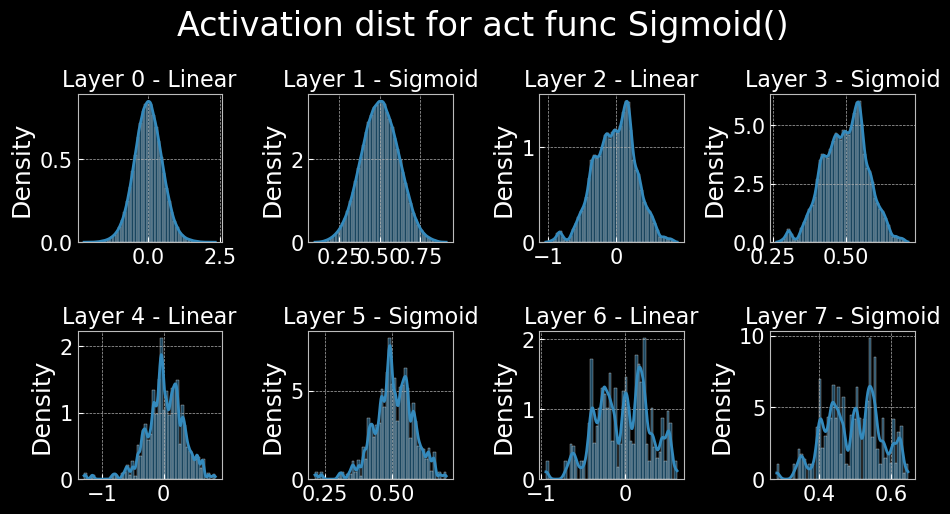

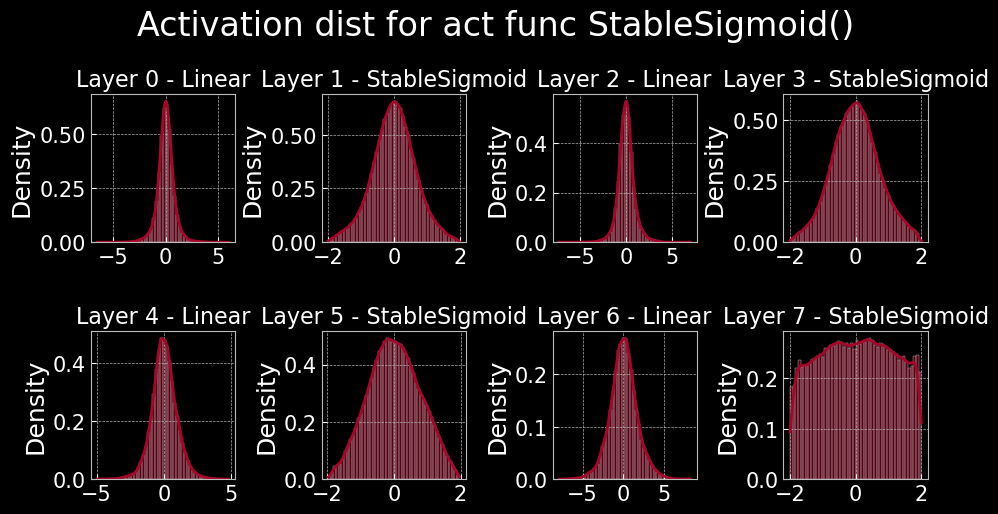

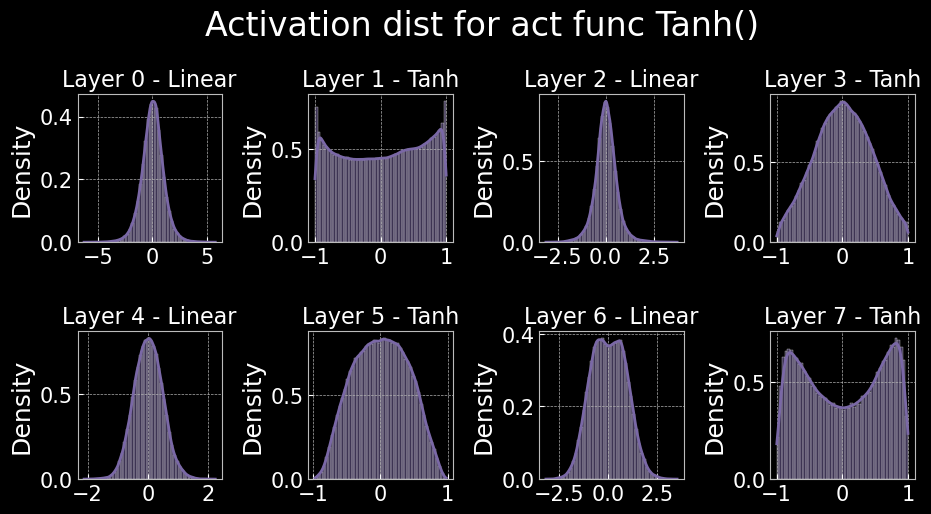

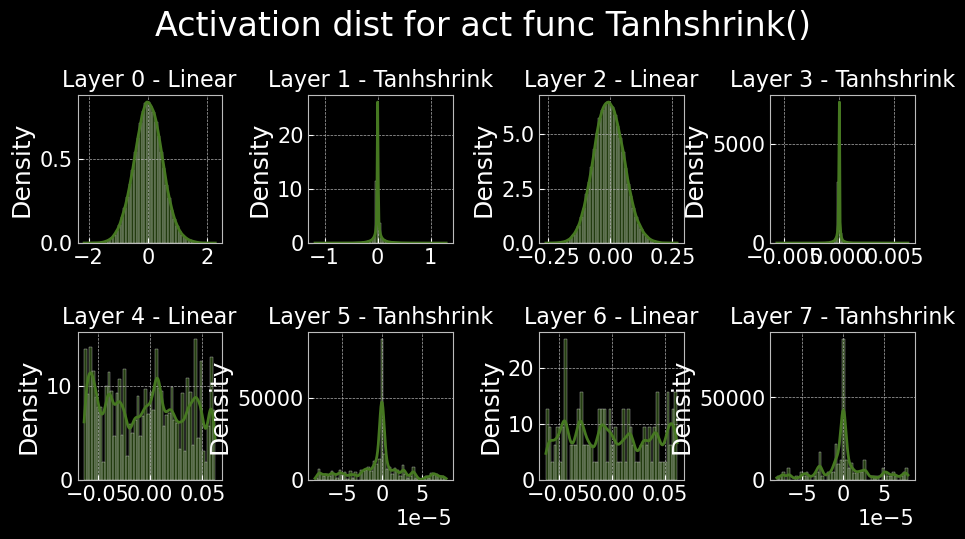

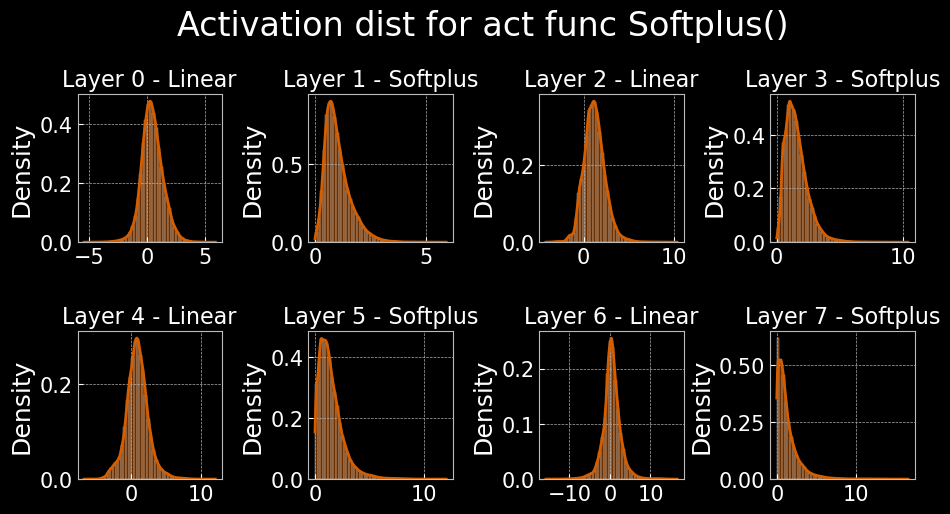

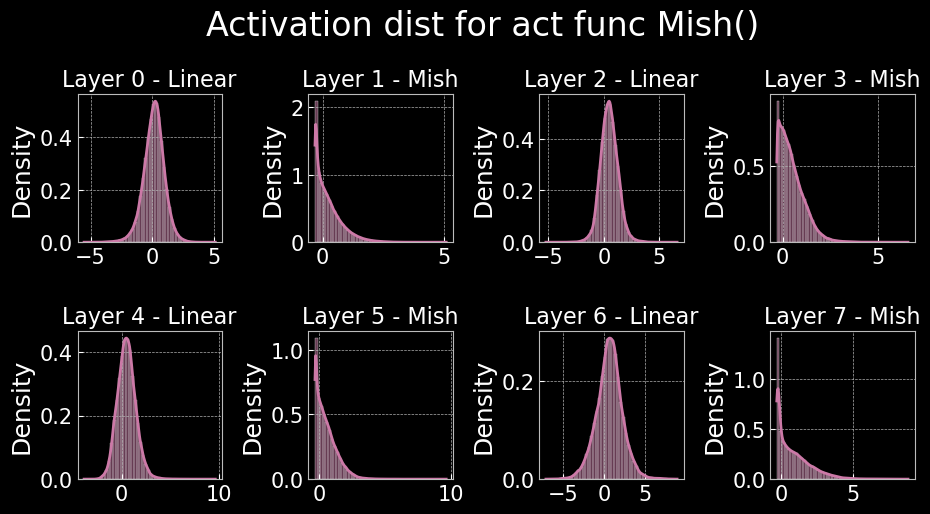

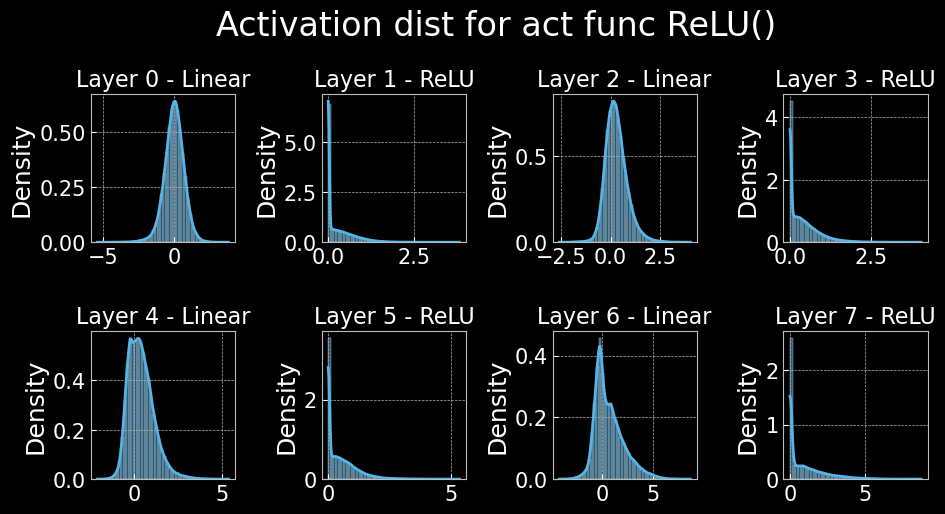

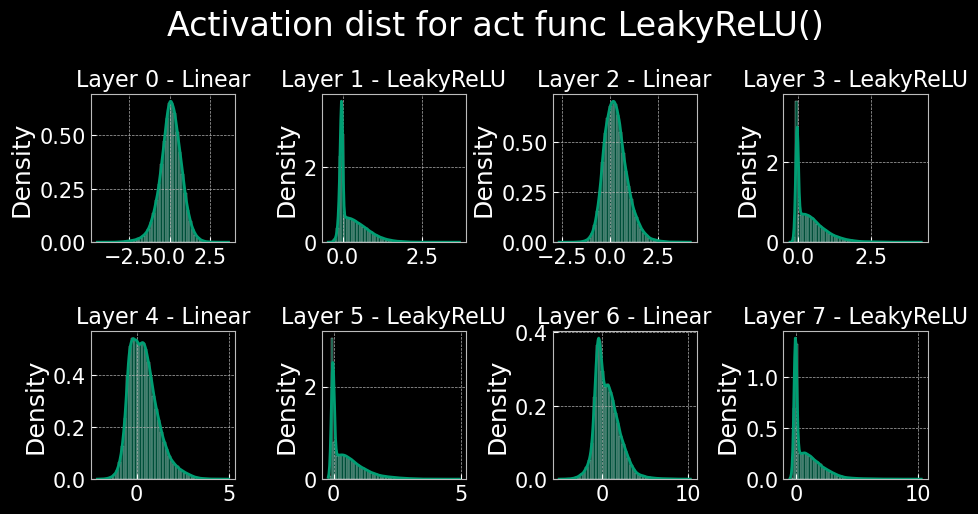

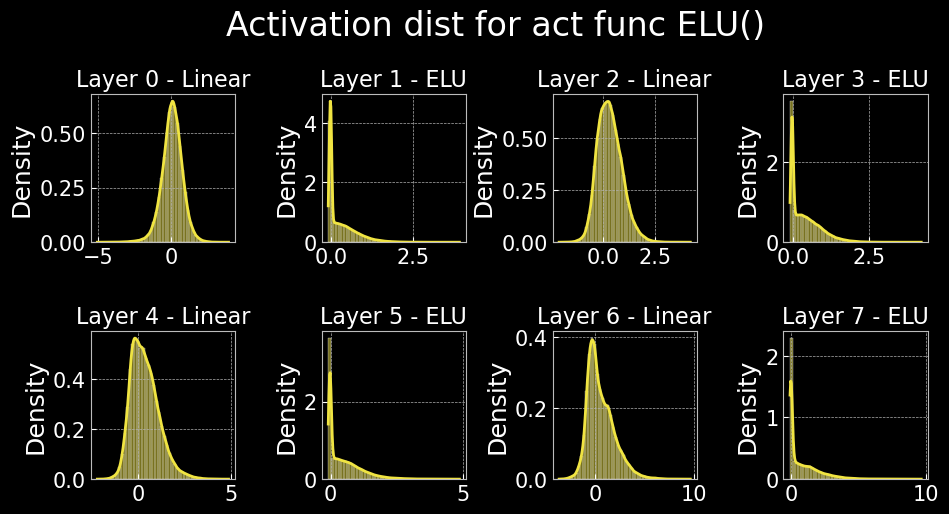

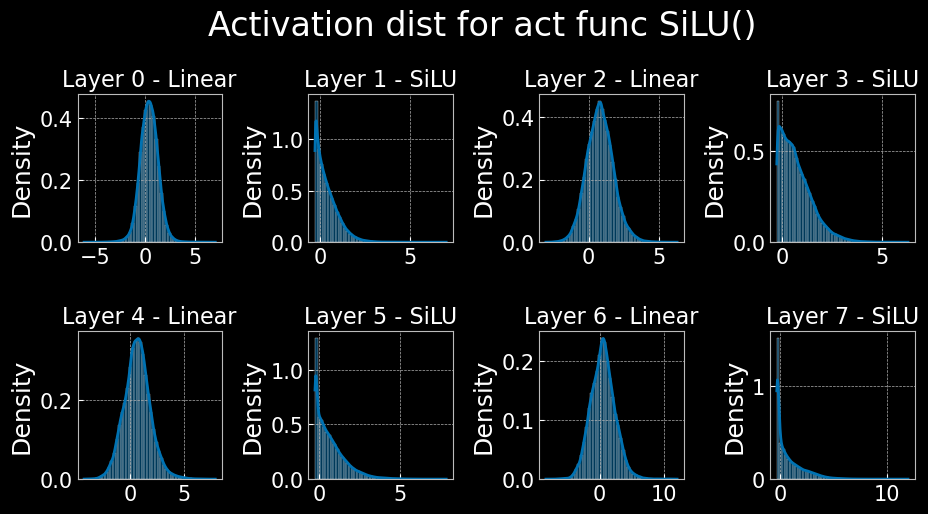

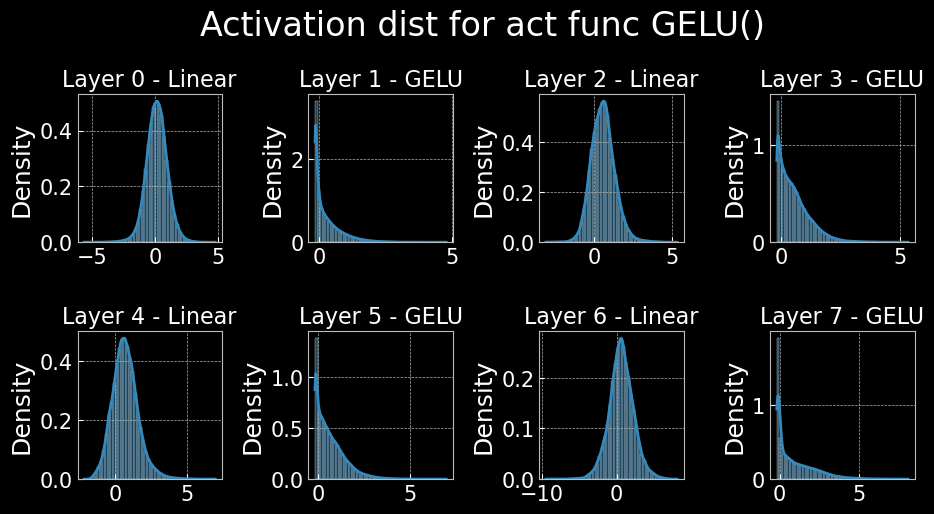

In [16]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    # Plotting
    columns = 4
    rows = int(np.ceil(len(activations)/columns))
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(
            data=activations[key], bins=50, ax=key_ax, 
            color=color, kde=True, stat="density")
        key_ax.set_title(
            "Layer %i - %s" % (key, net.layers[key].__class__.__name__), 
            fontsize=16)
        # key_ax.set_xticklabels(key_ax.get_xticklabels(), rotation=30)
        fig_index += 1

    fig.suptitle("Activation dist for act func %s" % (net.act_fn), fontsize=24, y=1.05)
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    plt.show()
    plt.close() 


for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = load_model(
        model_path=CHECKPOINT_PATH, 
        model_name="FashionMNIST_%s" % act_fn_name,
        act_fn=act_fn
    ).to(device)
    visualize_activations(net_actfn, color="C%i" % i)
    # break

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.

# Finding Dead Neurons in ReLU Networks

One known drawback of the ReLU activation is the occurrence of "dead neurons", i.e. neurons with no gradient for any training input.
The issue of dead neurons is that as no gradient is provided for the layer, we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.
For dead neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all input images.
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen. 

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. For this, we implement a function which runs the network on the whole training set and records whether a neuron is exactly 0 for all data points or not:

In [48]:
def measure_number_dead_neurons(net, act_fn_name='relu'):
    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    # neurons_dead: Same shapes as hidden size in BaseNN
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) \
            for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ]

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False):
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, act_fn_by_name[act_fn_name]):
                    # Update the buffer neurons_dead[layer_index] with the activations on the new batch
                    neurons_dead[layer_index] = torch.logical_and(
                        neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1

    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join(["%4.2f%%" % (100.0 * num_dead / tens.shape[0]) for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

## For ReLU

We see that only a minor amount of neurons are dead, but that they increase with the depth of the layer.
However, this is not a problem for the small number of dead neurons we have as the input to later layers is changed due to updates to the weights of previous layers. Therefore, dead neurons in later layers can potentially become "alive"/active again. 

How does this look like for a trained network (with the same initialization)?

The number of dead neurons indeed decreased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as it is), training the network cannot turn those neurons back active. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons.

In [35]:
# for trained model
ACT_FUNC = 'relu'
demo_act_fn = act_fn_by_name[ACT_FUNC]()
demo_nn = load_model(
        model_path=CHECKPOINT_PATH, 
        model_name="FashionMNIST_%s" % ACT_FUNC,
        act_fn=demo_act_fn
    ).to(device)

measure_number_dead_neurons(demo_nn)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 1, 4, 7]
In percentage: 0.00%, 0.39%, 1.56%, 5.47%


In [38]:
# for untrained model (the result is pretty unstable, depends on the init value, but generally, the number of dead neurons is higher)
demo_nn_2 = BaseNN(act_fn=demo_act_fn).to(device)
measure_number_dead_neurons(demo_nn_2)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 1, 2, 9]
In percentage: 0.00%, 0.39%, 0.78%, 7.03%


Finally, we check how the number of dead neurons behaves with increasing layer depth. For instance, let's take the following 10-layer neural network:

The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 56% of the neurons in the pre-last layer are dead which creates a considerable bottleneck.

Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

In [34]:
# for large model
demo_nn_3 = BaseNN(act_fn=demo_act_fn, 
                   hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(demo_nn_3)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 30, 70, 53, 53, 66, 47, 66]
In percentage: 0.00%, 0.00%, 1.17%, 11.72%, 27.34%, 41.41%, 41.41%, 51.56%, 36.72%, 51.56%


## For SiLU

In [49]:
# for trained model
ACT_FUNC = 'silu'
demo_act_fn = act_fn_by_name[ACT_FUNC]()
demo_nn = load_model(
        model_path=CHECKPOINT_PATH, 
        model_name="FashionMNIST_%s" % ACT_FUNC,
        act_fn=demo_act_fn
    ).to(device)

# cprint(demo_nn, demo_act_fn)
measure_number_dead_neurons(demo_nn, ACT_FUNC)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%


In [50]:
# for untrained model
demo_nn_2 = BaseNN(act_fn=demo_act_fn).to(device)
measure_number_dead_neurons(demo_nn_2, ACT_FUNC)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%


In [51]:
# for large model
demo_nn_3 = BaseNN(act_fn=demo_act_fn, 
                   hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(demo_nn_3, ACT_FUNC)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%
